# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [5]:
print(torch.__version__)

0.3.1


In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=250  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=64, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=64, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

class Seed_Layer(nn.Module):
    def __init__(self, in_channels):
        super(Seed_Layer,self).__init__()
        
        self.weight= Parameter(torch.Tensor(1,in_channels))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.uniform_(self.weight.data,-1,1) # More Method
    
    def forward(self):
#         a=torch.randn(1)*0.1
#         print_prob=0.36  # 控制显示tensor信息的概率
#         if a>print_prob:
#             print(self.weight)
            
        return self.weight


class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=False)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.seed_layer=Seed_Layer(in_planes)

    def forward(self, x):
        
        # 【bs,c_in,h,w】
        out = F.relu6(self.bn1(self.conv1(x)))
        # 【bs,c_in,h,w】,if stride==1,else 【bs,c_in,h/2,w/2】
        
        # -------------------------- Attention -----------------------
        w=self.seed_layer()
      
        in_channel=w.shape[1]
     
        w=w.view(1,1,in_channel) # 改变格式
        
        w=self.scaleLayer(w)  #自动缩放层 可以激活或者不激活 甚至采用多级缩放    
        
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #--------------------通过非线性激活函数-----------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
            
        # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out




class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,230,250], gamma=0.1)
criterion = nn.CrossEntropyLoss()

AttributeError: module 'torch.nn.init' has no attribute 'uniform_'

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 10*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
#from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.305618, Accuracy: 12.30
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.091362, Accuracy: 19.34
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.864752, Accuracy: 27.15
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.768861, Accuracy: 34.96
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.639829, Accuracy: 36.13
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.638906, Accuracy: 35.74
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.556471, Accuracy: 38.48
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.584472, Accuracy: 41.02
Train Epoch: 0 [40960/50000 (91%)]	Loss: 1.596120, Accuracy: 42.77

Validation set: Average loss: 1.5421, Accuracy: 2144/5000 (42.00%)

the time of this epoch:[33.94873595237732 s]
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.379137, Accuracy: 47.85
Train Epoch: 1 [5120/50000 (11%)]	Loss: 1.390101, Accuracy: 50.78
Train Epoch: 1 [10240/50000 (23%)]	Loss: 1.430366, Accuracy: 47.66
Train Epoch: 1 [15360/50000 (34%)]	Loss: 1.281760, Accuracy: 53.52
Train Epoch: 1 [20480/50000

Train Epoch: 11 [25600/50000 (57%)]	Loss: 0.504439, Accuracy: 83.79
Train Epoch: 11 [30720/50000 (68%)]	Loss: 0.467344, Accuracy: 84.38
Train Epoch: 11 [35840/50000 (80%)]	Loss: 0.428752, Accuracy: 84.57
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.417556, Accuracy: 85.94

Validation set: Average loss: 0.6456, Accuracy: 3925/5000 (78.00%)

the time of this epoch:[37.53510403633118 s]
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.443263, Accuracy: 85.74
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.408391, Accuracy: 84.57
Train Epoch: 12 [10240/50000 (23%)]	Loss: 0.422368, Accuracy: 84.96
Train Epoch: 12 [15360/50000 (34%)]	Loss: 0.484397, Accuracy: 82.23
Train Epoch: 12 [20480/50000 (45%)]	Loss: 0.404702, Accuracy: 86.91
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.417299, Accuracy: 85.94
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.432583, Accuracy: 84.18
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.450028, Accuracy: 85.74
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.467890, Accuracy: 83.59

Validat

Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.320532, Accuracy: 89.84
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.328340, Accuracy: 87.70
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.341835, Accuracy: 89.06
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.356043, Accuracy: 87.70

Validation set: Average loss: 0.5396, Accuracy: 4093/5000 (81.00%)

the time of this epoch:[34.089179277420044 s]

Test set: Average loss: 0.5827, Accuracy: 8072/10000 (80.72%)

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.322103, Accuracy: 88.28
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.301773, Accuracy: 87.89
Train Epoch: 23 [10240/50000 (23%)]	Loss: 0.369942, Accuracy: 87.70
Train Epoch: 23 [15360/50000 (34%)]	Loss: 0.296166, Accuracy: 90.23
Train Epoch: 23 [20480/50000 (45%)]	Loss: 0.344801, Accuracy: 89.65
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.267726, Accuracy: 90.62
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.306480, Accuracy: 89.45
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.328974, Accuracy: 89.45
Train Epoch

Train Epoch: 33 [20480/50000 (45%)]	Loss: 0.303438, Accuracy: 89.65
Train Epoch: 33 [25600/50000 (57%)]	Loss: 0.291811, Accuracy: 89.84
Train Epoch: 33 [30720/50000 (68%)]	Loss: 0.251979, Accuracy: 92.58
Train Epoch: 33 [35840/50000 (80%)]	Loss: 0.320883, Accuracy: 88.67
Train Epoch: 33 [40960/50000 (91%)]	Loss: 0.244910, Accuracy: 91.41

Validation set: Average loss: 0.7285, Accuracy: 3888/5000 (77.00%)

the time of this epoch:[37.61842751502991 s]
Train Epoch: 34 [0/50000 (0%)]	Loss: 0.280035, Accuracy: 91.41
Train Epoch: 34 [5120/50000 (11%)]	Loss: 0.238939, Accuracy: 92.77
Train Epoch: 34 [10240/50000 (23%)]	Loss: 0.256411, Accuracy: 90.23
Train Epoch: 34 [15360/50000 (34%)]	Loss: 0.287066, Accuracy: 89.45
Train Epoch: 34 [20480/50000 (45%)]	Loss: 0.277123, Accuracy: 91.02
Train Epoch: 34 [25600/50000 (57%)]	Loss: 0.252827, Accuracy: 90.82
Train Epoch: 34 [30720/50000 (68%)]	Loss: 0.327711, Accuracy: 89.06
Train Epoch: 34 [35840/50000 (80%)]	Loss: 0.300652, Accuracy: 89.26
Train Ep

Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.316272, Accuracy: 89.45
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.242294, Accuracy: 92.58
Train Epoch: 44 [30720/50000 (68%)]	Loss: 0.285212, Accuracy: 91.21
Train Epoch: 44 [35840/50000 (80%)]	Loss: 0.252421, Accuracy: 91.60
Train Epoch: 44 [40960/50000 (91%)]	Loss: 0.270351, Accuracy: 91.60

Validation set: Average loss: 0.5145, Accuracy: 4155/5000 (83.00%)

the time of this epoch:[34.058778524398804 s]

Test set: Average loss: 0.5516, Accuracy: 8254/10000 (82.54%)

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.226849, Accuracy: 93.16
Train Epoch: 45 [5120/50000 (11%)]	Loss: 0.225203, Accuracy: 92.19
Train Epoch: 45 [10240/50000 (23%)]	Loss: 0.269120, Accuracy: 91.02
Train Epoch: 45 [15360/50000 (34%)]	Loss: 0.302377, Accuracy: 90.04
Train Epoch: 45 [20480/50000 (45%)]	Loss: 0.241881, Accuracy: 92.77
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.239172, Accuracy: 91.21
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.258484, Accuracy: 90.43
Train Epoch

Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.218433, Accuracy: 93.16
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.213091, Accuracy: 92.97
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.213801, Accuracy: 92.58
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.282762, Accuracy: 89.45
Train Epoch: 55 [35840/50000 (80%)]	Loss: 0.250169, Accuracy: 91.80
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.242896, Accuracy: 92.19

Validation set: Average loss: 1.1583, Accuracy: 3406/5000 (68.00%)

the time of this epoch:[37.30617880821228 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.204337, Accuracy: 93.75
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.237627, Accuracy: 92.58
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.233759, Accuracy: 92.58
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.198721, Accuracy: 93.95
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.280429, Accuracy: 90.62
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.260532, Accuracy: 90.82
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.264483, Accuracy: 91.02
Train Ep

Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.212118, Accuracy: 92.77
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.236628, Accuracy: 92.58
Train Epoch: 66 [25600/50000 (57%)]	Loss: 0.232774, Accuracy: 91.21
Train Epoch: 66 [30720/50000 (68%)]	Loss: 0.206206, Accuracy: 91.99
Train Epoch: 66 [35840/50000 (80%)]	Loss: 0.240803, Accuracy: 91.99
Train Epoch: 66 [40960/50000 (91%)]	Loss: 0.230635, Accuracy: 91.99

Validation set: Average loss: 0.7820, Accuracy: 3886/5000 (77.00%)

the time of this epoch:[34.056560039520264 s]

Test set: Average loss: 0.7985, Accuracy: 7747/10000 (77.47%)

Train Epoch: 67 [0/50000 (0%)]	Loss: 0.219529, Accuracy: 92.19
Train Epoch: 67 [5120/50000 (11%)]	Loss: 0.249469, Accuracy: 93.16
Train Epoch: 67 [10240/50000 (23%)]	Loss: 0.251446, Accuracy: 91.21
Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.156161, Accuracy: 95.31
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.211973, Accuracy: 92.38
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.258174, Accuracy: 91.21
Train Epoch

Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.226315, Accuracy: 93.16
Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.238994, Accuracy: 91.80
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.208666, Accuracy: 91.99
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.221216, Accuracy: 92.77
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.275803, Accuracy: 90.43
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.234758, Accuracy: 91.99
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.196662, Accuracy: 92.97

Validation set: Average loss: 0.4485, Accuracy: 4257/5000 (85.00%)

the time of this epoch:[37.37731957435608 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.156786, Accuracy: 93.75
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.194020, Accuracy: 93.16
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.188320, Accuracy: 93.95
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.190646, Accuracy: 92.77
Train Epoch: 78 [20480/50000 (45%)]	Loss: 0.187369, Accuracy: 94.14
Train Epoch: 78 [25600/50000 (57%)]	Loss: 0.175988, Accuracy: 94.73
Train Ep

Train Epoch: 88 [10240/50000 (23%)]	Loss: 0.197978, Accuracy: 92.38
Train Epoch: 88 [15360/50000 (34%)]	Loss: 0.162357, Accuracy: 93.55
Train Epoch: 88 [20480/50000 (45%)]	Loss: 0.333247, Accuracy: 87.89
Train Epoch: 88 [25600/50000 (57%)]	Loss: 0.269718, Accuracy: 91.02
Train Epoch: 88 [30720/50000 (68%)]	Loss: 0.226805, Accuracy: 92.77
Train Epoch: 88 [35840/50000 (80%)]	Loss: 0.203127, Accuracy: 93.16
Train Epoch: 88 [40960/50000 (91%)]	Loss: 0.254647, Accuracy: 92.38

Validation set: Average loss: 0.6762, Accuracy: 4049/5000 (80.00%)

the time of this epoch:[34.12930727005005 s]

Test set: Average loss: 0.6880, Accuracy: 8002/10000 (80.02%)

Train Epoch: 89 [0/50000 (0%)]	Loss: 0.179589, Accuracy: 94.14
Train Epoch: 89 [5120/50000 (11%)]	Loss: 0.180497, Accuracy: 94.73
Train Epoch: 89 [10240/50000 (23%)]	Loss: 0.165898, Accuracy: 93.95
Train Epoch: 89 [15360/50000 (34%)]	Loss: 0.218131, Accuracy: 92.77
Train Epoch: 89 [20480/50000 (45%)]	Loss: 0.205972, Accuracy: 92.58
Train Epoch:

Train Epoch: 99 [5120/50000 (11%)]	Loss: 0.209689, Accuracy: 91.99
Train Epoch: 99 [10240/50000 (23%)]	Loss: 0.202249, Accuracy: 92.58
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.275346, Accuracy: 91.21
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.256940, Accuracy: 91.02
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.206740, Accuracy: 92.77
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.204877, Accuracy: 92.97
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.195576, Accuracy: 92.58
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.189306, Accuracy: 94.34

Validation set: Average loss: 0.7043, Accuracy: 3987/5000 (79.00%)

the time of this epoch:[37.35052728652954 s]
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.214582, Accuracy: 92.58
Train Epoch: 100 [5120/50000 (11%)]	Loss: 0.205488, Accuracy: 94.53
Train Epoch: 100 [10240/50000 (23%)]	Loss: 0.234372, Accuracy: 91.60
Train Epoch: 100 [15360/50000 (34%)]	Loss: 0.257254, Accuracy: 91.02
Train Epoch: 100 [20480/50000 (45%)]	Loss: 0.209702, Accuracy: 93.36
Trai

Train Epoch: 110 [0/50000 (0%)]	Loss: 0.235030, Accuracy: 91.99
Train Epoch: 110 [5120/50000 (11%)]	Loss: 0.164959, Accuracy: 94.34
Train Epoch: 110 [10240/50000 (23%)]	Loss: 0.184507, Accuracy: 93.36
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.212824, Accuracy: 91.60
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.163138, Accuracy: 94.34
Train Epoch: 110 [25600/50000 (57%)]	Loss: 0.181316, Accuracy: 94.34
Train Epoch: 110 [30720/50000 (68%)]	Loss: 0.221581, Accuracy: 92.38
Train Epoch: 110 [35840/50000 (80%)]	Loss: 0.306959, Accuracy: 88.67
Train Epoch: 110 [40960/50000 (91%)]	Loss: 0.225552, Accuracy: 91.60

Validation set: Average loss: 0.6281, Accuracy: 4067/5000 (81.00%)

the time of this epoch:[34.04708385467529 s]

Test set: Average loss: 0.6638, Accuracy: 8082/10000 (80.82%)

Train Epoch: 111 [0/50000 (0%)]	Loss: 0.186889, Accuracy: 94.14
Train Epoch: 111 [5120/50000 (11%)]	Loss: 0.190387, Accuracy: 94.14
Train Epoch: 111 [10240/50000 (23%)]	Loss: 0.213636, Accuracy: 93.16
Train 


Validation set: Average loss: 0.6146, Accuracy: 4075/5000 (81.00%)

the time of this epoch:[34.09513235092163 s]

Test set: Average loss: 0.6596, Accuracy: 8013/10000 (80.13%)

Train Epoch: 121 [0/50000 (0%)]	Loss: 0.155495, Accuracy: 95.12
Train Epoch: 121 [5120/50000 (11%)]	Loss: 0.195014, Accuracy: 92.97
Train Epoch: 121 [10240/50000 (23%)]	Loss: 0.200129, Accuracy: 93.75
Train Epoch: 121 [15360/50000 (34%)]	Loss: 0.138959, Accuracy: 94.92
Train Epoch: 121 [20480/50000 (45%)]	Loss: 0.207930, Accuracy: 93.55
Train Epoch: 121 [25600/50000 (57%)]	Loss: 0.182979, Accuracy: 93.55
Train Epoch: 121 [30720/50000 (68%)]	Loss: 0.227647, Accuracy: 92.58
Train Epoch: 121 [35840/50000 (80%)]	Loss: 0.228913, Accuracy: 91.80
Train Epoch: 121 [40960/50000 (91%)]	Loss: 0.226239, Accuracy: 91.80

Validation set: Average loss: 0.6251, Accuracy: 4068/5000 (81.00%)

the time of this epoch:[37.34467887878418 s]
Train Epoch: 122 [0/50000 (0%)]	Loss: 0.207144, Accuracy: 92.58
Train Epoch: 122 [5120/50000 

Train Epoch: 131 [30720/50000 (68%)]	Loss: 0.209328, Accuracy: 92.58
Train Epoch: 131 [35840/50000 (80%)]	Loss: 0.167016, Accuracy: 94.14
Train Epoch: 131 [40960/50000 (91%)]	Loss: 0.198717, Accuracy: 93.16

Validation set: Average loss: 0.4374, Accuracy: 4330/5000 (86.00%)

the time of this epoch:[37.349656105041504 s]
Train Epoch: 132 [0/50000 (0%)]	Loss: 0.170169, Accuracy: 93.95
Train Epoch: 132 [5120/50000 (11%)]	Loss: 0.188845, Accuracy: 92.19
Train Epoch: 132 [10240/50000 (23%)]	Loss: 0.188612, Accuracy: 94.14
Train Epoch: 132 [15360/50000 (34%)]	Loss: 0.206406, Accuracy: 93.55
Train Epoch: 132 [20480/50000 (45%)]	Loss: 0.176215, Accuracy: 94.34
Train Epoch: 132 [25600/50000 (57%)]	Loss: 0.187790, Accuracy: 93.36
Train Epoch: 132 [30720/50000 (68%)]	Loss: 0.193220, Accuracy: 93.36
Train Epoch: 132 [35840/50000 (80%)]	Loss: 0.251683, Accuracy: 91.21
Train Epoch: 132 [40960/50000 (91%)]	Loss: 0.168650, Accuracy: 94.53

Validation set: Average loss: 0.5216, Accuracy: 4202/5000 (84.

Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.195882, Accuracy: 93.55
Train Epoch: 142 [25600/50000 (57%)]	Loss: 0.210138, Accuracy: 92.58
Train Epoch: 142 [30720/50000 (68%)]	Loss: 0.209758, Accuracy: 91.80
Train Epoch: 142 [35840/50000 (80%)]	Loss: 0.207058, Accuracy: 92.38
Train Epoch: 142 [40960/50000 (91%)]	Loss: 0.202109, Accuracy: 92.77

Validation set: Average loss: 0.6705, Accuracy: 4036/5000 (80.00%)

the time of this epoch:[34.02020478248596 s]

Test set: Average loss: 0.6850, Accuracy: 8006/10000 (80.06%)

Train Epoch: 143 [0/50000 (0%)]	Loss: 0.147737, Accuracy: 96.48
Train Epoch: 143 [5120/50000 (11%)]	Loss: 0.115628, Accuracy: 96.68
Train Epoch: 143 [10240/50000 (23%)]	Loss: 0.180157, Accuracy: 92.77
Train Epoch: 143 [15360/50000 (34%)]	Loss: 0.174849, Accuracy: 93.36
Train Epoch: 143 [20480/50000 (45%)]	Loss: 0.140975, Accuracy: 95.70
Train Epoch: 143 [25600/50000 (57%)]	Loss: 0.198560, Accuracy: 94.34
Train Epoch: 143 [30720/50000 (68%)]	Loss: 0.226032, Accuracy: 91.21


Train Epoch: 153 [5120/50000 (11%)]	Loss: 0.066365, Accuracy: 97.85
Train Epoch: 153 [10240/50000 (23%)]	Loss: 0.065023, Accuracy: 98.05
Train Epoch: 153 [15360/50000 (34%)]	Loss: 0.073584, Accuracy: 98.44
Train Epoch: 153 [20480/50000 (45%)]	Loss: 0.056161, Accuracy: 98.44
Train Epoch: 153 [25600/50000 (57%)]	Loss: 0.053094, Accuracy: 98.24
Train Epoch: 153 [30720/50000 (68%)]	Loss: 0.063451, Accuracy: 97.66
Train Epoch: 153 [35840/50000 (80%)]	Loss: 0.044827, Accuracy: 99.02
Train Epoch: 153 [40960/50000 (91%)]	Loss: 0.062773, Accuracy: 98.24

Validation set: Average loss: 0.2396, Accuracy: 4643/5000 (92.00%)

the time of this epoch:[37.28919553756714 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.066115, Accuracy: 98.05
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.067547, Accuracy: 97.66
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.066675, Accuracy: 97.27
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.042182, Accuracy: 98.63
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.059544, Accuracy: 97

Train Epoch: 164 [0/50000 (0%)]	Loss: 0.012559, Accuracy: 99.80
Train Epoch: 164 [5120/50000 (11%)]	Loss: 0.028229, Accuracy: 99.22
Train Epoch: 164 [10240/50000 (23%)]	Loss: 0.019594, Accuracy: 99.61
Train Epoch: 164 [15360/50000 (34%)]	Loss: 0.014412, Accuracy: 99.61
Train Epoch: 164 [20480/50000 (45%)]	Loss: 0.014250, Accuracy: 99.61
Train Epoch: 164 [25600/50000 (57%)]	Loss: 0.029300, Accuracy: 99.22
Train Epoch: 164 [30720/50000 (68%)]	Loss: 0.009556, Accuracy: 100.00
Train Epoch: 164 [35840/50000 (80%)]	Loss: 0.017364, Accuracy: 99.22
Train Epoch: 164 [40960/50000 (91%)]	Loss: 0.023197, Accuracy: 99.22

Validation set: Average loss: 0.2731, Accuracy: 4655/5000 (93.00%)

the time of this epoch:[34.0256986618042 s]

Test set: Average loss: 0.2928, Accuracy: 9277/10000 (92.77%)

Train Epoch: 165 [0/50000 (0%)]	Loss: 0.020005, Accuracy: 99.61
Train Epoch: 165 [5120/50000 (11%)]	Loss: 0.015905, Accuracy: 99.80
Train Epoch: 165 [10240/50000 (23%)]	Loss: 0.029411, Accuracy: 99.02
Train 


Validation set: Average loss: 0.2917, Accuracy: 4656/5000 (93.00%)

the time of this epoch:[33.99149036407471 s]

Test set: Average loss: 0.3209, Accuracy: 9236/10000 (92.36%)

Train Epoch: 175 [0/50000 (0%)]	Loss: 0.030879, Accuracy: 98.63
Train Epoch: 175 [5120/50000 (11%)]	Loss: 0.026986, Accuracy: 99.02
Train Epoch: 175 [10240/50000 (23%)]	Loss: 0.009825, Accuracy: 99.80
Train Epoch: 175 [15360/50000 (34%)]	Loss: 0.029476, Accuracy: 99.02
Train Epoch: 175 [20480/50000 (45%)]	Loss: 0.013371, Accuracy: 99.41
Train Epoch: 175 [25600/50000 (57%)]	Loss: 0.005216, Accuracy: 100.00
Train Epoch: 175 [30720/50000 (68%)]	Loss: 0.011015, Accuracy: 99.80
Train Epoch: 175 [35840/50000 (80%)]	Loss: 0.025627, Accuracy: 98.83
Train Epoch: 175 [40960/50000 (91%)]	Loss: 0.006844, Accuracy: 100.00

Validation set: Average loss: 0.3012, Accuracy: 4656/5000 (93.00%)

the time of this epoch:[37.25164580345154 s]
Train Epoch: 176 [0/50000 (0%)]	Loss: 0.011287, Accuracy: 99.80
Train Epoch: 176 [5120/5000

Train Epoch: 185 [30720/50000 (68%)]	Loss: 0.020569, Accuracy: 99.41
Train Epoch: 185 [35840/50000 (80%)]	Loss: 0.013346, Accuracy: 99.61
Train Epoch: 185 [40960/50000 (91%)]	Loss: 0.006782, Accuracy: 99.80

Validation set: Average loss: 0.3252, Accuracy: 4650/5000 (93.00%)

the time of this epoch:[37.37263631820679 s]
Train Epoch: 186 [0/50000 (0%)]	Loss: 0.013992, Accuracy: 99.22
Train Epoch: 186 [5120/50000 (11%)]	Loss: 0.010412, Accuracy: 99.80
Train Epoch: 186 [10240/50000 (23%)]	Loss: 0.008518, Accuracy: 99.80
Train Epoch: 186 [15360/50000 (34%)]	Loss: 0.010072, Accuracy: 99.80
Train Epoch: 186 [20480/50000 (45%)]	Loss: 0.004528, Accuracy: 100.00
Train Epoch: 186 [25600/50000 (57%)]	Loss: 0.016310, Accuracy: 99.41
Train Epoch: 186 [30720/50000 (68%)]	Loss: 0.011052, Accuracy: 99.80
Train Epoch: 186 [35840/50000 (80%)]	Loss: 0.014227, Accuracy: 99.80
Train Epoch: 186 [40960/50000 (91%)]	Loss: 0.010715, Accuracy: 99.80

Validation set: Average loss: 0.3132, Accuracy: 4662/5000 (93.

Train Epoch: 196 [20480/50000 (45%)]	Loss: 0.013873, Accuracy: 99.80
Train Epoch: 196 [25600/50000 (57%)]	Loss: 0.016955, Accuracy: 99.22
Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.015024, Accuracy: 99.41
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.005364, Accuracy: 100.00
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.010634, Accuracy: 99.80

Validation set: Average loss: 0.3162, Accuracy: 4651/5000 (93.00%)

the time of this epoch:[34.0065758228302 s]

Test set: Average loss: 0.3384, Accuracy: 9236/10000 (92.36%)

Train Epoch: 197 [0/50000 (0%)]	Loss: 0.010053, Accuracy: 99.61
Train Epoch: 197 [5120/50000 (11%)]	Loss: 0.011425, Accuracy: 99.61
Train Epoch: 197 [10240/50000 (23%)]	Loss: 0.018769, Accuracy: 99.41
Train Epoch: 197 [15360/50000 (34%)]	Loss: 0.011544, Accuracy: 99.61
Train Epoch: 197 [20480/50000 (45%)]	Loss: 0.008675, Accuracy: 99.61
Train Epoch: 197 [25600/50000 (57%)]	Loss: 0.028875, Accuracy: 99.22
Train Epoch: 197 [30720/50000 (68%)]	Loss: 0.015311, Accuracy: 99.61


Train Epoch: 207 [5120/50000 (11%)]	Loss: 0.004006, Accuracy: 99.80
Train Epoch: 207 [10240/50000 (23%)]	Loss: 0.003672, Accuracy: 100.00
Train Epoch: 207 [15360/50000 (34%)]	Loss: 0.002478, Accuracy: 100.00
Train Epoch: 207 [20480/50000 (45%)]	Loss: 0.003772, Accuracy: 100.00
Train Epoch: 207 [25600/50000 (57%)]	Loss: 0.002686, Accuracy: 100.00
Train Epoch: 207 [30720/50000 (68%)]	Loss: 0.002390, Accuracy: 100.00
Train Epoch: 207 [35840/50000 (80%)]	Loss: 0.003474, Accuracy: 100.00
Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.004826, Accuracy: 99.80

Validation set: Average loss: 0.3106, Accuracy: 4670/5000 (93.00%)

the time of this epoch:[37.25379300117493 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.006103, Accuracy: 99.80
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.002680, Accuracy: 100.00
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.004303, Accuracy: 100.00
Train Epoch: 208 [15360/50000 (34%)]	Loss: 0.014730, Accuracy: 99.61
Train Epoch: 208 [20480/50000 (45%)]	Loss: 0.002680, Accu


Validation set: Average loss: 0.3083, Accuracy: 4670/5000 (93.00%)

the time of this epoch:[36.79482364654541 s]
Train Epoch: 218 [0/50000 (0%)]	Loss: 0.002402, Accuracy: 100.00
Train Epoch: 218 [5120/50000 (11%)]	Loss: 0.002653, Accuracy: 100.00
Train Epoch: 218 [10240/50000 (23%)]	Loss: 0.002767, Accuracy: 100.00
Train Epoch: 218 [15360/50000 (34%)]	Loss: 0.002233, Accuracy: 100.00
Train Epoch: 218 [20480/50000 (45%)]	Loss: 0.002666, Accuracy: 100.00
Train Epoch: 218 [25600/50000 (57%)]	Loss: 0.004761, Accuracy: 100.00
Train Epoch: 218 [30720/50000 (68%)]	Loss: 0.003121, Accuracy: 100.00
Train Epoch: 218 [35840/50000 (80%)]	Loss: 0.013352, Accuracy: 99.80
Train Epoch: 218 [40960/50000 (91%)]	Loss: 0.002910, Accuracy: 100.00

Validation set: Average loss: 0.3092, Accuracy: 4671/5000 (93.00%)

the time of this epoch:[33.959552526474 s]

Test set: Average loss: 0.3325, Accuracy: 9270/10000 (92.70%)

Train Epoch: 219 [0/50000 (0%)]	Loss: 0.005159, Accuracy: 100.00
Train Epoch: 219 [5120

Train Epoch: 228 [30720/50000 (68%)]	Loss: 0.007156, Accuracy: 99.80
Train Epoch: 228 [35840/50000 (80%)]	Loss: 0.002700, Accuracy: 100.00
Train Epoch: 228 [40960/50000 (91%)]	Loss: 0.002592, Accuracy: 100.00

Validation set: Average loss: 0.3070, Accuracy: 4668/5000 (93.00%)

the time of this epoch:[34.050211668014526 s]

Test set: Average loss: 0.3306, Accuracy: 9267/10000 (92.67%)

Train Epoch: 229 [0/50000 (0%)]	Loss: 0.002153, Accuracy: 100.00
Train Epoch: 229 [5120/50000 (11%)]	Loss: 0.002353, Accuracy: 100.00
Train Epoch: 229 [10240/50000 (23%)]	Loss: 0.001649, Accuracy: 100.00
Train Epoch: 229 [15360/50000 (34%)]	Loss: 0.002342, Accuracy: 100.00
Train Epoch: 229 [20480/50000 (45%)]	Loss: 0.003984, Accuracy: 100.00
Train Epoch: 229 [25600/50000 (57%)]	Loss: 0.009271, Accuracy: 99.80
Train Epoch: 229 [30720/50000 (68%)]	Loss: 0.009192, Accuracy: 99.80
Train Epoch: 229 [35840/50000 (80%)]	Loss: 0.003967, Accuracy: 99.80
Train Epoch: 229 [40960/50000 (91%)]	Loss: 0.001792, Accuracy

Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.002682, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.002268, Accuracy: 100.00
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.002936, Accuracy: 100.00
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.003718, Accuracy: 100.00
Train Epoch: 239 [30720/50000 (68%)]	Loss: 0.004846, Accuracy: 99.80
Train Epoch: 239 [35840/50000 (80%)]	Loss: 0.005764, Accuracy: 99.80
Train Epoch: 239 [40960/50000 (91%)]	Loss: 0.003043, Accuracy: 100.00

Validation set: Average loss: 0.3114, Accuracy: 4675/5000 (93.00%)

the time of this epoch:[37.333340644836426 s]
Train Epoch: 240 [0/50000 (0%)]	Loss: 0.006222, Accuracy: 99.80
Train Epoch: 240 [5120/50000 (11%)]	Loss: 0.004611, Accuracy: 99.80
Train Epoch: 240 [10240/50000 (23%)]	Loss: 0.003209, Accuracy: 100.00
Train Epoch: 240 [15360/50000 (34%)]	Loss: 0.002079, Accuracy: 100.00
Train Epoch: 240 [20480/50000 (45%)]	Loss: 0.003655, Accuracy: 100.00
Train Epoch: 240 [25600/50000 (57%)]	Loss: 0.003884, Ac


Test set: Average loss: 0.3316, Accuracy: 9273/10000 (92.73%)



# Step 3: Test

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

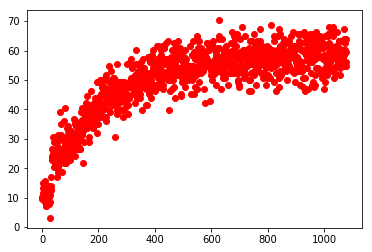

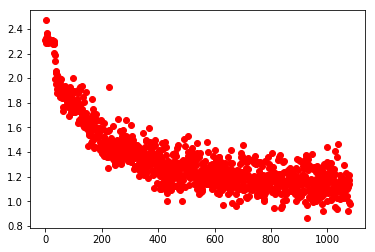

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

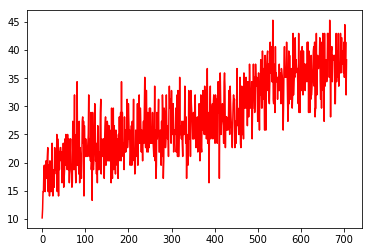

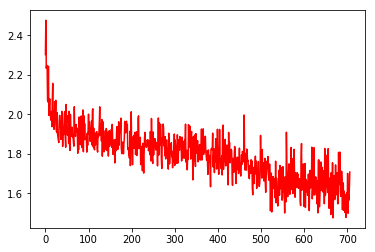

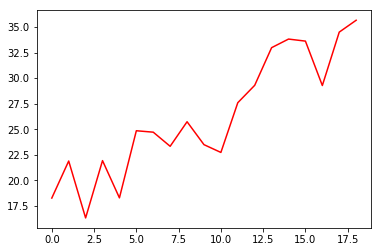

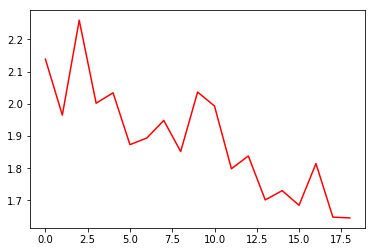

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()